In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
import statistics

In [2]:
#cutoff = 7.068872962487293e-06 # 75% quantile (see if we choose 25% or 10% quantile)
cutoff = 0.25 # arbitrarily chosen

In [3]:
data = pd.read_csv("/Users/HaoWoo/Desktop/Bio_Research/training_data.csv")
data["output"] = 0
data.loc[data["sqr_diff"]>=cutoff,"output"] = 1
print (data) 

                  pred  neighbor_min  neighbor_med  neighbor_max  \
0         1.000000e+00  3.448735e-01      0.999999      1.000000   
1         2.303483e-01  1.373577e-02      0.356021      1.000000   
2         1.214818e-02  5.842320e-03      0.022058      0.806485   
3         7.544638e-03  5.842320e-03      0.010829      0.024479   
4         9.081059e-03  8.041023e-03      0.011586      0.017962   
...                ...           ...           ...           ...   
23585333  1.923477e-03  2.356266e-07      0.000063      1.000000   
23585334  8.860329e-07  2.356266e-07      0.000010      0.949198   
23585335  1.000000e+00  9.134875e-06      0.974640      1.000000   
23585336  1.729165e-04  1.150460e-06      0.001329      1.000000   
23585337  1.000000e+00  1.915087e-03      0.999998      1.000000   

          neighbor_mean  neighbor_sd      sqr_diff  output  
0              0.887225     0.217816  6.646194e-16       0  
1              0.502149     0.419060  5.923637e-01       1  


In [4]:
temp = data[data["output"]==1]
print (temp)

              pred  neighbor_min  neighbor_med  neighbor_max  neighbor_mean  \
1         0.230348  1.373577e-02      0.356021      1.000000       0.502149   
3         0.007545  5.842320e-03      0.010829      0.024479       0.011325   
4         0.009081  8.041023e-03      0.011586      0.017962       0.012287   
5         0.008514  6.695674e-03      0.010781      0.017560       0.011011   
26        0.004094  3.606462e-03      0.004888      0.006863       0.005037   
...            ...           ...           ...           ...            ...   
23585036  0.000003  9.738538e-07      0.000012      0.001354       0.000071   
23585037  0.000013  9.738538e-07      0.000010      0.000104       0.000017   
23585137  0.387997  1.118313e-06      0.000367      0.864051       0.040129   
23585220  0.335821  2.571513e-05      0.040167      0.925816       0.183203   
23585311  0.350767  2.036824e-05      0.001298      1.000000       0.263970   

          neighbor_sd  sqr_diff  output  
1        

In [5]:
data_samples = data.shape[0]

X_train = (data.iloc[0:int(data_samples*85/100),0:6]).to_numpy().T
Y_train = (data.iloc[0:int(data_samples*85/100),7]).to_numpy().reshape([int(data_samples*85/100),1]).T

X_test = (data.iloc[int(data_samples*85/100):,0:6]).to_numpy().T
Y_test = (data.iloc[int(data_samples*85/100):,7]).to_numpy().reshape([data_samples-int(data_samples*85/100),1]).T

print (X_train.shape) #(6, 20047537)
print (Y_train.shape) #(1, 20047537)
print (X_test.shape) #(6, 3537801)
print (Y_test.shape) #(6, 3537801)

(6, 20047537)
(1, 20047537)
(6, 3537801)
(1, 3537801)


## Helper Functions
Activating Function - Sigmoid

In [6]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1/(1+np.exp(-z))

    return s

In [7]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    w = np.zeros((dim,1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [8]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (6, 1)
    b -- bias, a scalar
    X -- data of size (6, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1] # number of examples
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                                    # compute activation
    cost = (-np.dot(Y,(np.log(A)).T)-np.dot(1-Y, (np.log(1-A)).T))/m                                 # compute cost

    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = np.dot(X, (A-Y).T)/m
    db = np.sum(A-Y)/m

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [9]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (6, 1)
    b -- bias, a scalar
    X -- data of shape (6, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in tqdm(range(num_iterations)):
        
        
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [10]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (6, 1)
    b -- bias, a scalar
    X -- data of size (6, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in tqdm(range(A.shape[1])):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0][i] <= 0.5:
            Y_prediction[0][i] = 0
        else:
            Y_prediction[0][i] = 1
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [11]:
# helper function from get_training_data.ipynb

def get_neighbors(x,y,n,s,matrix):
    '''
    x -- x position of data point
    y -- y position of data point
    n -- neighbor range (integer)
    s -- size of the numpy matrix where data point lies
    matrix -- numpy matrix where data point lies
    '''
    
    perm = list(itertools.product(list(range(max(x-n,0),min(x+n+1,s))),list(range(max(y-n,0),min(y+n+1,s)))))
    perm.remove((x,y))
    half_perm_values = [matrix[p[0]][p[1]] for p in perm if p[0]<=p[1]]
    
    return (min(half_perm_values),statistics.median(half_perm_values),max(half_perm_values),statistics.mean(half_perm_values),statistics.stdev(half_perm_values))



In [22]:
def predict_from_contact_pred(w, b, nb_range, c_p):
    '''
    Based on contact_pred matrix, apply the model to predict whether label of 
    each data point is 0 (correct) or 1 (error) using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (6, 1)
    b -- bias, a scalar
    nb_range -- neighbor range
    c_p -- contact_pred matrix
    
    Returns:
    result_matrix -- numpy matrix containing all predictions of error (0/1) for contact_pred matrix
    '''
    
    # visualize contact_pred matrix
    fig_1 = plt.figure(dpi=200)
    ax_1 = fig_1.add_subplot(111)
    cax_1 = ax_1.matshow(c_p, interpolation='nearest')
    fig_1.colorbar(cax_1)
    plt.show()
    
    # generate model input X from contact_pred matrix
    size = c_p.shape[0]
    pred_value = []
    neighbor_value = []
    points_ind = list(itertools.product(list(range(0,size)),list(range(0,size))))
    pred_value += [c_p[p[0]][p[1]] for p in points_ind if p[0]<=p[1]]
    neighbor_value += [get_neighbors(p[0],p[1],nb_range,size,c_p) for p in points_ind if p[0]<=p[1]]
    df_pred = pd.DataFrame(pred_value, columns = ["pred"])
    df_neighbor = pd.DataFrame(neighbor_value, columns=["neighbor_min", "neighbor_med", "neighbor_max", "neighbor_mean", "neighbor_sd"])
    df_X = pd.concat([df_pred, df_neighbor], axis=1)
    X = df_X.to_numpy().T # has shape (6, number of data points)
    
    # apply model to predict whether label of each data point in X is 0 (correct) or 1 (error)
    m = X.shape[1] # number of data points
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in tqdm(range(A.shape[1])):
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0][i] <= 0.5:
            Y_prediction[0][i] = 0
        else:
            Y_prediction[0][i] = 1
    
    assert(Y_prediction.shape == (1, m))
    
    result_matrix = np.zeros(c_p.shape)
    for i in range(len(Y_prediction)):
        result_matrix[points_ind[i][0]][points_ind[i][1]] = Y_prediction[0][i]
        result_matrix[points_ind[i][1]][points_ind[i][0]] = Y_prediction[0][i]
    
    # visualize result matrix
    fig_2 = plt.figure(dpi=200)
    ax_2 = fig_2.add_subplot(111)
    cax_2 = ax_2.matshow(result_matrix, interpolation='nearest')
    fig_2.colorbar(cax_2)
    plt.show()
    
    return result_matrix

## Model Function & Model Tuning

### 1. Model Function

In [13]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 500, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function implemented above
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (6, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (6, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros
    w, b = initialize_with_zeros(np.shape(X_train)[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = True)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    model_result = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return model_result

Train a model and get details about model:
1. Model Accuracy (training & testing)
2. Learning Curve

In [14]:
model_result = model(X_train, Y_train, X_test, Y_test, num_iterations = 1500, learning_rate = 0.5, print_cost = False)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.192397
Cost after iteration 200: 0.191021
Cost after iteration 300: 0.190433
Cost after iteration 400: 0.190132
Cost after iteration 500: 0.189958
Cost after iteration 600: 0.189840
Cost after iteration 700: 0.189747
Cost after iteration 800: 0.189665
Cost after iteration 900: 0.189591
Cost after iteration 1000: 0.189521
Cost after iteration 1100: 0.189454
Cost after iteration 1200: 0.189391
Cost after iteration 1300: 0.189331
Cost after iteration 1400: 0.189272




train accuracy: 95.25056369767518 %
test accuracy: 95.54536843649487 %


[[ 0.67370607]
 [ 0.022515  ]
 [-0.5746235 ]
 [ 0.37055206]
 [-0.04130868]
 [ 0.15048823]]
-3.1031029972171704


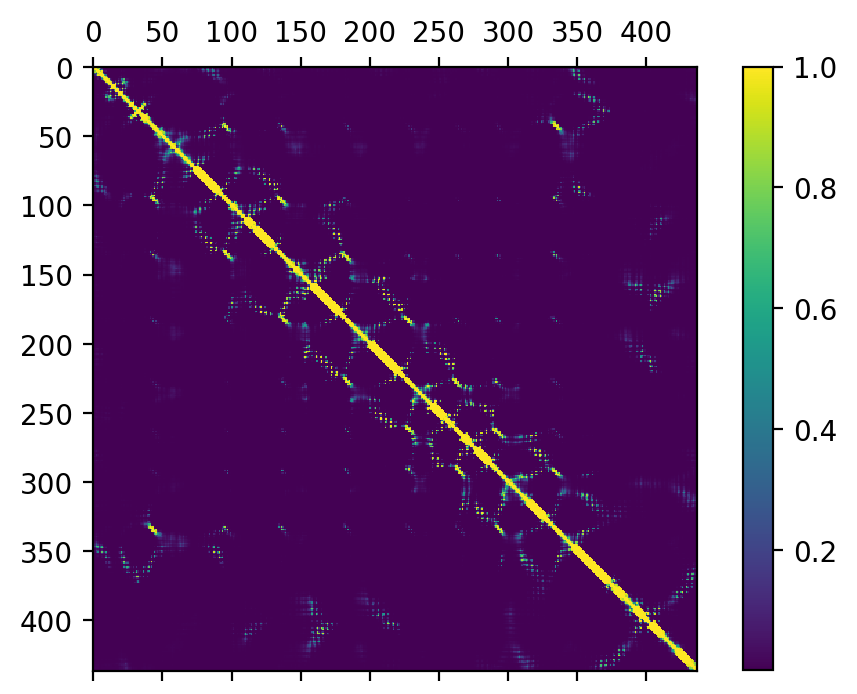

In [ ]:
print (model_result["w"])
print (model_result["b"])
try_c_p = np.load("contact_predictions/1A0CA_contact_pred.npy")
try_result_matrix = predict_from_contact_pred(model_result["w"], model_result["b"], 1, try_c_p)
print (try_result_matrix)
print (np.amin(try_result_matrix),np.amax(try_result_matrix))

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(model_result['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(model_result["learning_rate"]))
plt.show()

### 2. Model Tuning

In [ ]:
# tuning learning rate
learning_rates = [0.25, 0.1, 0.05]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(X_train, Y_train, X_test, Y_test, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()